# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [2]:
!pip install category_encoders
!pip install catboost
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 3.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import FeatureHasher
from category_encoders.target_encoder import TargetEncoder
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from time import time

import warnings
warnings.filterwarnings('ignore')

from ipywidgets import IntProgress
from IPython.display import display

RS = 52

## Знакомство с данными

Загрузили данные, написали функцию для ознакомления с данными и использовали ее:

In [4]:
data = pd.read_csv('/datasets/autos.csv')

In [5]:
def check_data(df):
    # Посмотрели на сами данные
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(df.head())

    # Подсчитали пустые значения, уникальные значение и узнали типы данных в столбцах
    print ('\033[1m' + '\nПропуски и уникальные значения, типы данных'+ '\033[0m')
    rows_na = df.isna().sum().reset_index().rename(columns={0: "valuesNa"})
    rows_notna = df.notna().sum().reset_index().rename(columns={0: "valuesNotNa"})
    rows_analysis = pd.merge(rows_na, rows_notna, on="index", how= "outer")
    types = df.dtypes.reset_index().rename(columns={0: "types"})
    nunique = df.nunique().reset_index().rename(columns={0: "nunique"})
    rows_analysis = pd.merge(rows_analysis, nunique)
    rows_analysis = pd.merge(rows_analysis, types)
    display(rows_analysis)

    # Узнали размер датасета и кол-во дубликатов
    print("Размер:", df.shape)

    # Узнали количество дубликатов
    print('Количество полных дубликатов: ', df.duplicated().sum())

    # Посмотрели на статистику по количественным и категориальным признакам
    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(df.describe().T)
    print('\033[1m' + '\nОписание категориальных данных:'+ '\033[0m')
    display(df.describe(include='object').T)

    # Посмотрели на значения в категориальных признаках
    print('\033[1m' + '\nВывод уникальных значений по каждому категориаьному признаку:'+ '\033[0m')
    df_object = df.select_dtypes(include='object').columns
    for i in df_object:
        print('\033[1m' + '_'+ str(i) + '\033[0m')
        display(df[i].value_counts())


In [6]:
check_data(data)


Первые пять строк датасета


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Пропуски и уникальные значения, типы данных


,index,valuesNa,valuesNotNa,nunique,types
0,DateCrawled,0,354369,271174,object
1,Price,0,354369,3731,int64
2,VehicleType,37490,316879,8,object
3,RegistrationYear,0,354369,151,int64
4,Gearbox,19833,334536,2,object
5,Power,0,354369,712,int64
6,Model,19705,334664,250,object
7,Kilometer,0,354369,13,int64
8,RegistrationMonth,0,354369,13,int64
9,FuelType,32895,321474,7,object


Размер: (354369, 16)
Количество полных дубликатов:  4

Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0



Описание категориальных данных:


,count,unique,top,freq
DateCrawled,354369,271174,2016-03-24 14:49:47,7
VehicleType,316879,8,sedan,91457
Gearbox,334536,2,manual,268251
Model,334664,250,golf,29232
FuelType,321474,7,petrol,216352
Brand,354369,40,volkswagen,77013
Repaired,283215,2,no,247161
DateCreated,354369,109,2016-04-03 00:00:00,13719
LastSeen,354369,179150,2016-04-06 13:45:54,17



Вывод уникальных значений по каждому категориаьному признаку:
_DateCrawled


2016-03-24 14:49:47    7
2016-03-26 22:57:31    6
2016-03-19 21:49:56    6
2016-04-02 14:50:21    5
2016-03-23 13:50:19    5
                      ..
2016-03-20 16:48:06    1
2016-03-22 21:51:04    1
2016-03-11 16:25:36    1
2016-03-31 12:47:30    1
2016-03-19 18:57:12    1
Name: DateCrawled, Length: 271174, dtype: int64

_VehicleType


sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

_Gearbox


manual    268251
auto       66285
Name: Gearbox, dtype: int64

_Model


golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

_FuelType


petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

_Brand


volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64

_Repaired


no     247161
yes     36054
Name: Repaired, dtype: int64

_DateCreated


2016-04-03 00:00:00    13719
2016-04-04 00:00:00    13317
2016-03-20 00:00:00    12918
2016-03-12 00:00:00    12840
2016-03-21 00:00:00    12691
                       ...  
2015-08-07 00:00:00        1
2015-12-27 00:00:00        1
2015-11-12 00:00:00        1
2015-12-06 00:00:00        1
2015-06-18 00:00:00        1
Name: DateCreated, Length: 109, dtype: int64

_LastSeen


2016-04-06 13:45:54    17
2016-04-07 09:45:10    16
2016-04-06 01:15:23    16
2016-04-06 10:15:26    16
2016-04-07 05:44:30    16
                       ..
2016-03-07 17:46:17     1
2016-03-10 07:49:15     1
2016-04-03 04:18:11     1
2016-03-16 20:19:54     1
2016-03-21 10:42:49     1
Name: LastSeen, Length: 179150, dtype: int64

Написали функции для проверки распределения количественных данных и посмотрели на распределение данных:

In [7]:
def plot_hist(data, col_column):
    '''
    Функция отрисовки гистограмм и ящика с усами для количесвтенных переменных.
    На вход: исходная таблица и список количественных переменных.
    На выходе: графики
    '''
    rows = len(col_column)
    f, ax = plt.subplots(rows,2, figsize=(8, 15))
    f.tight_layout()
    f.set_figheight(30)
    f.set_figwidth(14)
    plt.rcParams.update({'font.size': 18})

    for i, col in enumerate(col_column):
        sns.histplot(data[col], kde=True, bins=24, ax = ax[i, 0])
        sns.boxplot(data[col], ax = ax[i, 1])

        ax[i, 0].set_xlabel(col)
        ax[i, 1].set_xlabel(col)
        ax[i, 0].set_ylabel('Количество')
    plt.suptitle("Гистограмма и ящик с усами для количесвтенных данных", fontsize=22, y=1.01)
    plt.show()

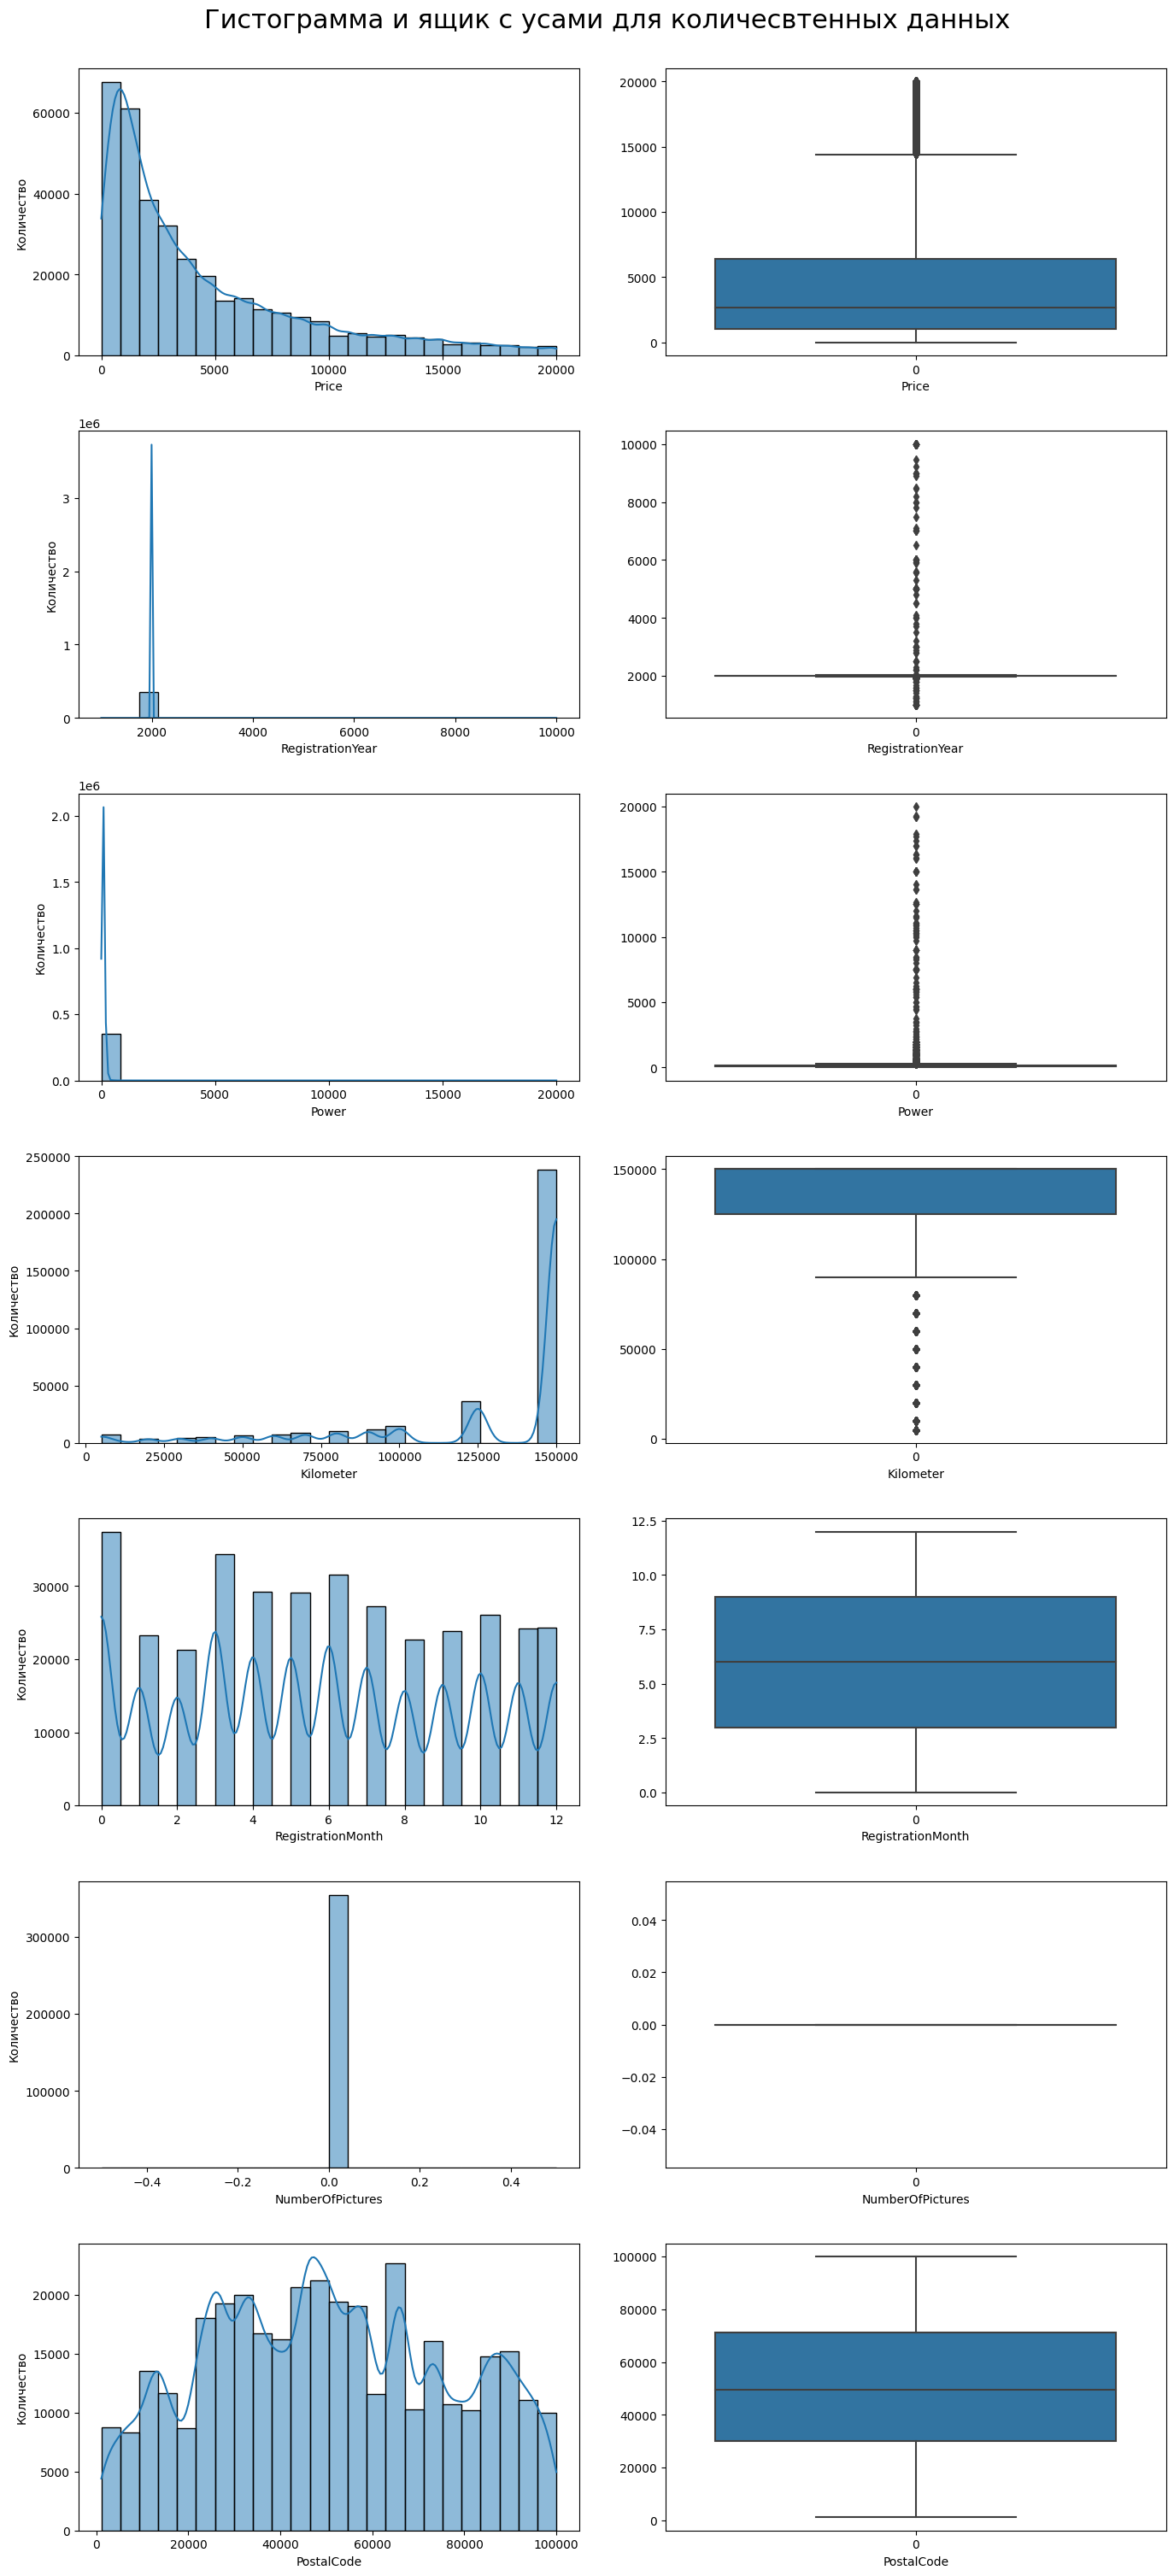

In [8]:
num_features = data.select_dtypes(exclude=[object]).columns
plot_hist(data, num_features)

Рассмотрели подробнее признак `RegistrationYear`:

66
105


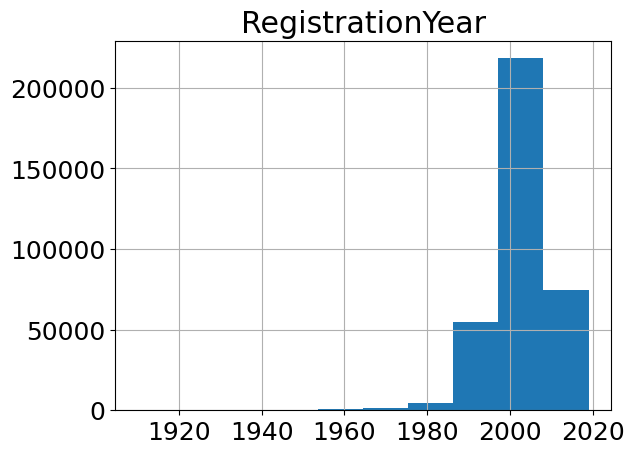

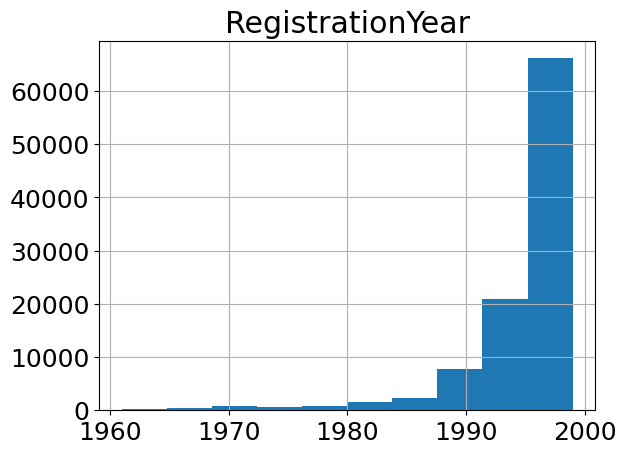

In [9]:
print((data['RegistrationYear'] < 1900).sum())
print((data['RegistrationYear'] > 2023).sum())
data.loc[(data['RegistrationYear'] < 2023) & (data['RegistrationYear'] > 1900), ['RegistrationYear']].hist()
plt.show()
plt.close()
data.loc[(data['RegistrationYear'] < 2000) & (data['RegistrationYear'] > 1960), ['RegistrationYear']].hist(bins=10)
plt.show()
plt.close()

Рассмотрели подробнее признак `Power`:

302


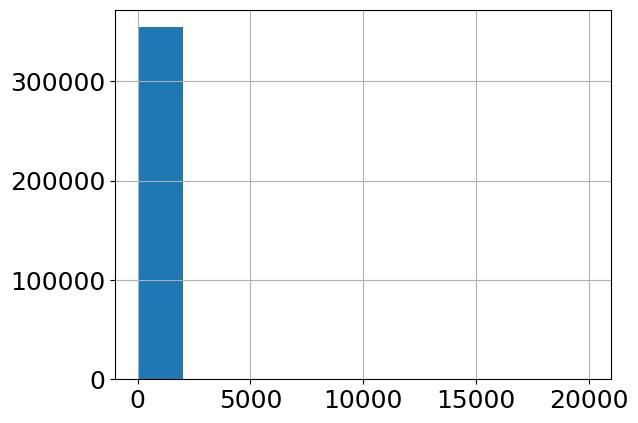

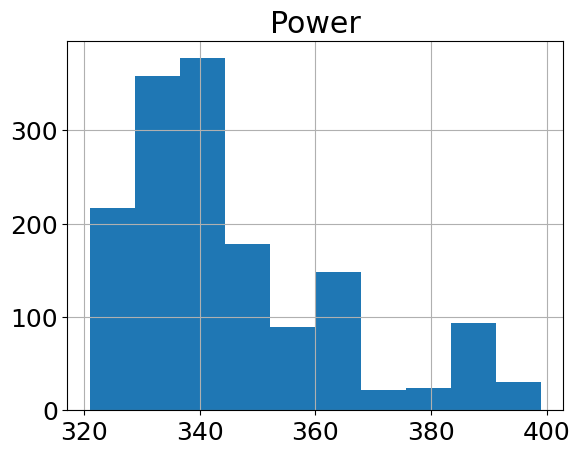

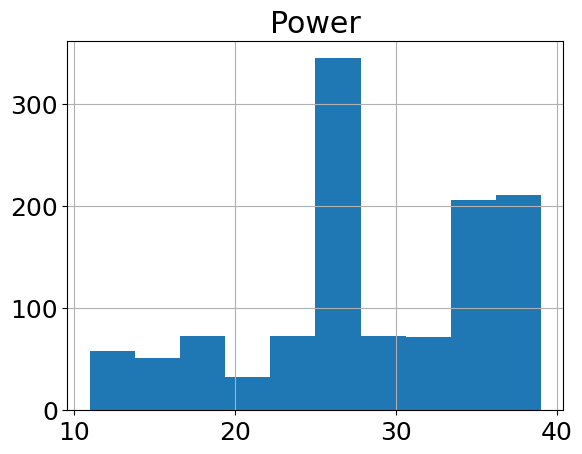

In [10]:
print((data['Power'] > 1000).sum())
data['Power'].hist()
plt.show()
plt.close()
data.loc[(data['Power'] > 320) & (data['Power'] < 400), ['Power']].hist(bins=10)
plt.show()
plt.close()
data.loc[(data['Power'] > 10) & (data['Power'] < 40), ['Power']].hist(bins=10)
plt.show()
plt.close()

Привели столбцы с датами к подходящему типу данных:

In [11]:
date_cols = ['LastSeen','DateCrawled','DateCreated']
for col in date_cols:
    data[col] =  pd.to_datetime(data[col])

Рассмотрели подробнее признаки `LastSeen`, `DateCrawled`, `DateCreated`:

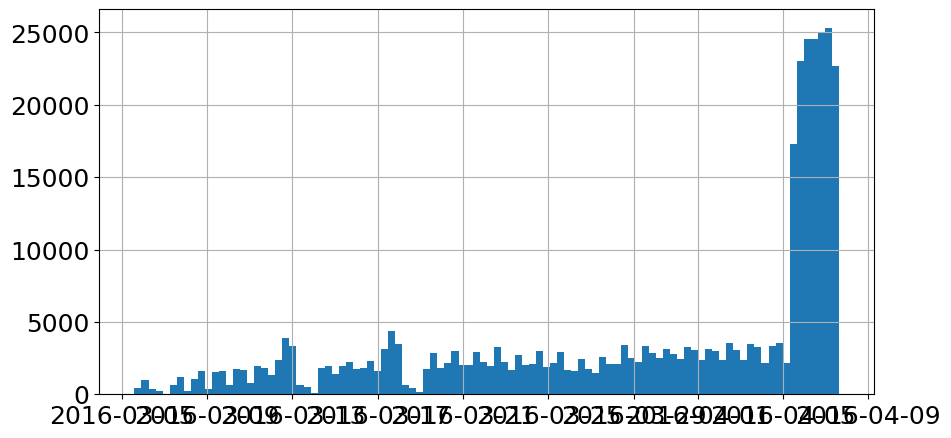

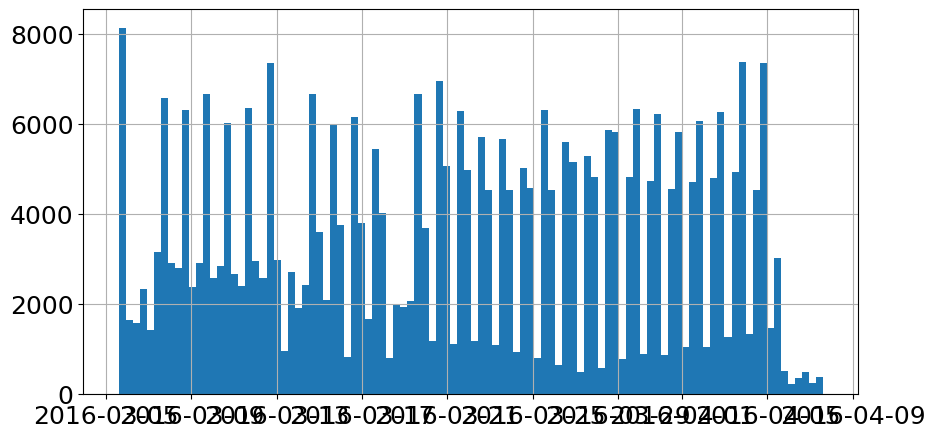

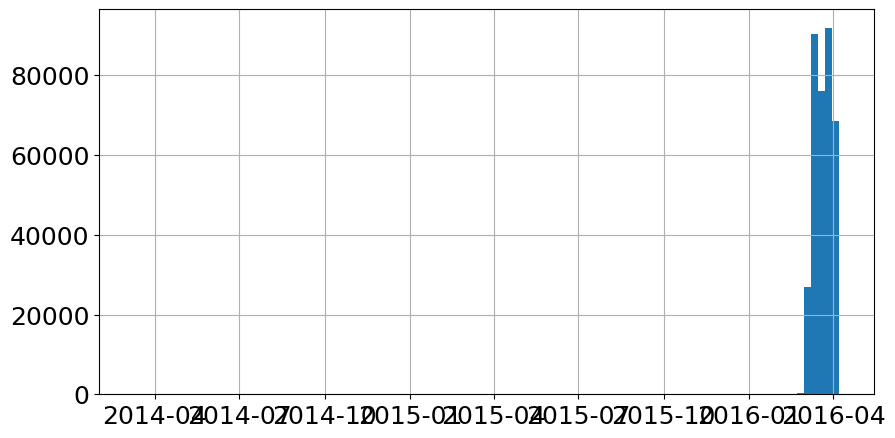

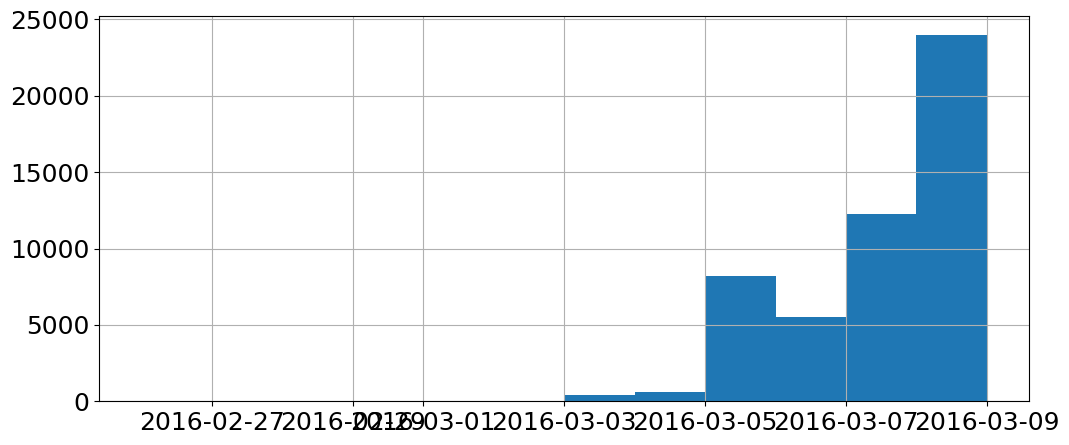

In [12]:
for col in date_cols:
    data[col].hist(bins=100,figsize=(10,5))
    plt.show()
    plt.close()
data.loc[(data['DateCreated'] > '2016-02-25') & (data['DateCreated'] < '2016-03-10'), 'DateCreated'].hist(figsize=(12,5), bins=12)
plt.show()
plt.close()

**Выводы после знакомства с данными:**
- Есть столбцы с неподходящим типом данных (уже исправлено)
- Есть 4 дубликата (необходимо удалить)
- Есть столбцы с пропусками: `Repaired`, `FuelType`, `Model`, `Gearbox`, `VehicleType` (все они категориальные, поэтому их придется заполнить новым признаком "unknown")
- Есть выбросы в столбцах `DateCreated`, `Power`, `RegistrationYear`, `Price`
- Есть столбцы не несущие полезной информации (подлежат удалению)
    - `NumberOfPictures` - количество фотографий (не несёт информации, так как одинаковое значение для всех объектов)
    - `PostalCode`(информация не влияет на целевой объект - цену автомобиля)
    - `DateCrawled` (информация не влияет на целевой объект - цену автомобиля)
    - `LastSeen` (информация не влияет на целевой объект - цену автомобиля)

Удалили полные дубликаты и ненужные столбцы:

In [13]:
data = data.drop_duplicates()
data = data.drop(['NumberOfPictures','PostalCode','DateCrawled','LastSeen','DateCreated'],axis=1)

display(data.head(2))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes


Удалили выбросы в столбцах, в которых они есть:

In [14]:
print(data.shape)
data = data.loc[(data['RegistrationYear'] >= 1970) & (data['RegistrationYear'] <= 2016)]
print(data.shape, '\n')

print(data.shape)
data = data.loc[(data['Power'] >= 25) & (data['Power'] <= 350)]
print(data.shape, '\n')

print(data.shape)
data = data.loc[(data['Price'] > 0)]
print(data.shape)


(354365, 11)
(338497, 11) 

(338497, 11)
(301033, 11) 

(301033, 11)
(294700, 11)


Создали функцию для заполнения пропусков в категориальных признаках, основываясь на значениях столбцов `Model` и `RegistrationYear` и применили её, также заполнили оставшиеся пропуски значением *'unknown'*:


In [15]:
def fill_na(df, col):
    col_mode_name = col + '_mode'
    modes = df.groupby(['Model', 'RegistrationYear'])[col].apply(lambda x: x.mode()).reset_index()
    df = df.merge(modes, on=['Model', 'RegistrationYear'], suffixes=('', '_mode'))
    df[col] = df[col].fillna(df[col_mode_name])
    df = df.drop(col_mode_name, axis=1)
    return df


In [16]:
for col in 'FuelType', 'Gearbox', 'VehicleType':
    data = fill_na(data, col)
data = data.drop(['level_2_mode', 'level_2'], axis=1)
data.isnull().sum()

Price                    0
VehicleType              0
RegistrationYear         0
Gearbox                  0
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType                 0
Brand                    0
Repaired             38584
dtype: int64

In [17]:
data['Repaired'] = data['Repaired'].fillna('unknown')
data.isnull().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64

**Выводы:**
- Удалили ненужные столбцы: `NumberOfPictures`,`PostalCode`,`DateCrawled`,`LastSeen`,`DateCreated`
- Удалили выбросы в столбцах: `RegistrationYear`, `Power`, `Price`
- Заполнили пропуски в столбцах `FuelType`, `Gearbox`, `VehicleType` используя моду в тех же категориях по столбцам `Model`, `RegistrationYear`
- Заполнили пропуски в столбце `Repaired` значением `unknown`.

## Анализ моделей

### Создание функций и подготовка выборок
Создали функцию для выделения целевого признака и разбивки на выборки и функцию для применения кросс валидации:


In [18]:
def y_X_split(data):
    y = data['Price']
    X = data.drop(['Price'], axis=1)
    train_X, test_X, train_y, test_y = train_test_split(X, y,  test_size=0.2, random_state=52, stratify=X['Model'])
    print('Размерность features тренировочной и тестовой выборок: ',train_X.shape, test_X.shape)
    print('Размерность target тренировочной и тестовой выборок: ',train_y.shape, test_y.shape)
    return train_X, test_X, train_y, test_y


In [19]:
def cross_valid(model_name, model, features, target):
    scores = cross_val_score(model, features, target, scoring='neg_root_mean_squared_error', cv=5)
    print(f'RMSE модели {model_name} на обучающей выборке: {-scores.mean()}')

Посмотрели на количество классов в каждом категориальном признаке:

In [20]:
data.describe(include=['object'])

,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
count,284632,284632,284632,284632,284632,284632
unique,8,2,249,7,39,3
top,sedan,manual,golf,petrol,volkswagen,no
freq,83670,227488,24777,191167,62176,218721


Разбили данные на выборки:

In [21]:
train_X, test_X, train_y, test_y = y_X_split(data)

Размерность features тренировочной и тестовой выборок:  (227705, 10) (56927, 10)
Размерность target тренировочной и тестовой выборок:  (227705,) (56927,)


### Кодирование признаков

Выделилили категориальные и численные признаки и закодировали их:

In [ ]:
cat_feat = list(train_X.select_dtypes(include=['object']).columns)
num_feat = list(train_X.select_dtypes(include=['int', 'float']).columns)
cat_feat_2 = train_X.select_dtypes(include='object').columns.to_list()
print(cat_feat, num_feat, cat_feat_2, sep='\n')

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


In [ ]:
display(train_X.shape)
display(test_X.shape)
train_X_ohe = train_X.copy()
test_X_ohe = test_X.copy()
display(train_X_ohe.shape)
display(test_X_ohe.shape)

(227708, 10)

(56928, 10)

(227708, 10)

(56928, 10)

In [ ]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
encoder_ohe.fit(train_X_ohe[cat_feat])
train_X_ohe[
    encoder_ohe.get_feature_names()
] = encoder_ohe.transform(train_X_ohe[cat_feat])
train_X_ohe = train_X_ohe.drop(cat_feat, axis=1)
print(train_X_ohe.shape)
print(train_X.shape)

(227708, 10)

In [ ]:
test_X_ohe[
    encoder_ohe.get_feature_names()
] = encoder_ohe.transform(test_X_ohe[cat_feat])

test_X_ohe = test_X_ohe.drop(cat_feat, axis=1)
print(test_X_ohe.shape)
print(test_X.shape)

(56928, 306)
(56928, 10)


In [ ]:
target_en = TargetEncoder()

target_en.fit(train_X[cat_feat], train_y)
train_X[cat_feat] = target_en.transform(train_X[cat_feat])
test_X[cat_feat] = target_en.transform(test_X[cat_feat])

display(train_X[cat_feat].head())
display(test_X[cat_feat].head())

,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
136586,2886.627202,4323.334850,1811.327425,3938.207089,3016.127475,5541.113437
277978,5740.617483,7162.106654,6723.890977,3938.207089,4413.038161,5541.113437
167356,4887.142042,7162.106654,4825.077544,3938.207089,4874.544331,5541.113437
3309,7033.340716,4323.334850,4507.146158,3938.207089,4874.544331,5541.113437
213123,4887.142042,4323.334850,3442.296342,3938.207089,4062.088785,5541.113437


,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
157028,6247.621907,4323.33485,5413.176321,3938.207089,6704.070215,5541.113437
192969,5171.398701,4323.33485,3965.464912,3938.207089,3107.107337,5541.113437
281643,5740.617483,4323.33485,2389.473118,3938.207089,2625.180584,5541.113437
47913,4887.142042,4323.33485,4507.146158,3938.207089,4874.544331,2156.857672
21024,5171.398701,4323.33485,4507.146158,6982.219028,4874.544331,5541.113437


### Стандартизация признаков

Стандартизировали численные признаки:

In [ ]:
scaler = StandardScaler()
scaler.fit(train_X[num_feat])

train_X[num_feat] = scaler.transform(train_X[num_feat])
test_X[num_feat] = scaler.transform(test_X[num_feat])

display(train_X[num_feat].head())
display(test_X[num_feat].head())

,RegistrationYear,Power,Kilometer,RegistrationMonth
136586,1.490368,-0.839518,-1.864331,0.830188
277978,0.999861,0.776585,-1.864331,0.269425
167356,-1.779682,1.049181,0.593349,1.110570
3309,-0.798667,-0.372211,0.593349,-1.693245
213123,0.018846,-0.430624,-0.089340,-0.852101


,RegistrationYear,Power,Kilometer,RegistrationMonth
157028,0.182348,0.445576,-0.089340,-0.852101
192969,0.018846,0.679229,0.593349,-0.291338
281643,-2.106687,-0.255384,0.593349,-1.412864
47913,-0.962170,-1.170527,0.593349,-0.571719
21024,-0.471662,-0.586393,0.593349,0.269425


### Линейная регрессия

Обучили модель Линейной регрессии и проверили её работу:

In [ ]:
%%time
lin_model = LinearRegression()
lin_model.fit(train_X_ohe, train_y)

CPU times: user 15.8 s, sys: 19 s, total: 34.8 s
Wall time: 34.8 s


LinearRegression()

In [ ]:
%%time
lin_pred = lin_model.predict(test_X_ohe)

CPU times: user 58.6 ms, sys: 65.9 ms, total: 124 ms
Wall time: 110 ms


In [ ]:
cross_valid('Линейная регрессия', lin_model, train_X_ohe, train_y)

RMSE модели Линейная регрессия на обучающей выборке: 2501.147558312035


Написали функцию для сохранения метрик по каждой модели и применили её здесь и в дальнейшем:

*Линейную регрессию включать не стали, ввиду её низкой конкурентоспособности*

In [ ]:
analisys = pd.DataFrame({'model':[], 'RMSE':[], 'time_to_predict':[]})
all_models = []

def train_model(model, parameters):

    model_random = RandomizedSearchCV(estimator=model,
                                      param_distributions=parameters, # используем параметры
                                      n_iter=50,
                                      scoring='neg_mean_absolute_error', # используем необходимую метрику
                                      cv=3,
                                      verbose=1,
                                      random_state=RS)

    # посмотрим время обучения
    start = time()
    model_random.fit(train_X, train_y)
    print('RandomizedSearchCV подбирал параметры %.2f секунд' %(time() - start))

    start = time()
    model_random.predict(train_X)
    time_to_predict = time() - start
    print('Модель предсказывает за %.2f секунд' %time_to_predict)

    # высчитаем метрики
    rmse = model_random.best_score_ * -1 ** 0.5

    print('Лучшие параметры:', model_random.best_params_)
    print('RMSE обученной модели:', rmse)

    # заполним все таблицы
    all_models.append(model_random)
    row = []
    row.extend([model, rmse, time_to_predict])
    analisys.loc[len(analisys.index)] = row

    return model_random, rmse

### Дерево решений

In [ ]:
tree_params = {"max_depth": list(range(15, 26))}

tree = DecisionTreeRegressor()

tree_model, tree_rmse = train_model(tree, tree_params)

Fitting 3 folds for each of 11 candidates, totalling 33 fits
RandomizedSearchCV подбирал параметры 17.79 секунд
Модель предсказывает за 0.04 секунд
Лучшие параметры: {'max_depth': 16}
RMSE обученной модели: 1095.2143749108782


### Случайный лес

In [ ]:
forest_params = {
    'max_depth': [11, 12, 13],
    'n_estimators': [10, 20, 30]
}


forest = RandomForestRegressor()

forest_model, forest_rmse = train_model(forest, forest_params) # обучим и сохраним значения

Fitting 3 folds for each of 9 candidates, totalling 27 fits
RandomizedSearchCV подбирал параметры 136.31 секунд
Модель предсказывает за 0.79 секунд
Лучшие параметры: {'n_estimators': 30, 'max_depth': 13}
RMSE обученной модели: 1036.9638605752502


### LGBMRegressor

In [ ]:
lgbm_param = {
    'max_depth': [5, 7, 9],
    'learning_rate': [0.1, 0.2]
    #'categorical_feature': cat_feat
    }

lgbm = LGBMRegressor(boosting_type='gbdt',
                     objective = 'regression',
                     metric = 'RMSE')
                     #categorical_feature = cat_feat)

lgbm_model, lgbm_rmse = train_model(lgbm, lgbm_param)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
RandomizedSearchCV подбирал параметры 267.11 секунд
Модель предсказывает за 1.31 секунд
Лучшие параметры: {'max_depth': 9, 'learning_rate': 0.2}
RMSE обученной модели: 1016.2052865510362


### Catboost

In [ ]:
cat_param = {
    'max_depth': [8, 9, 10],
    'learning_rate': [0.1, 0.2]
}

cat = CatBoostRegressor(verbose=False)

cat_model, cat_rmse = train_model(cat, cat_param)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
RandomizedSearchCV подбирал параметры 590.30 секунд
Модель предсказывает за 0.92 секунд
Лучшие параметры: {'max_depth': 10, 'learning_rate': 0.2}
RMSE обученной модели: 927.9228770695709


Построили и вывели целевую метрику, которой удалось достичь по каждой модели и время, затраченное на работу модели:

,model,RMSE,time_to_predict,names
0,DecisionTreeRegressor(),1095.214375,0.042180,DecisionTree
1,RandomForestRegressor(),1036.963861,0.787912,RandomForest
2,"LGBMRegressor(metric='RMSE', objective='regres...",1016.205287,1.314619,LightGBM
3,<catboost.core.CatBoostRegressor object at 0x7...,927.922877,0.922435,CatBoost


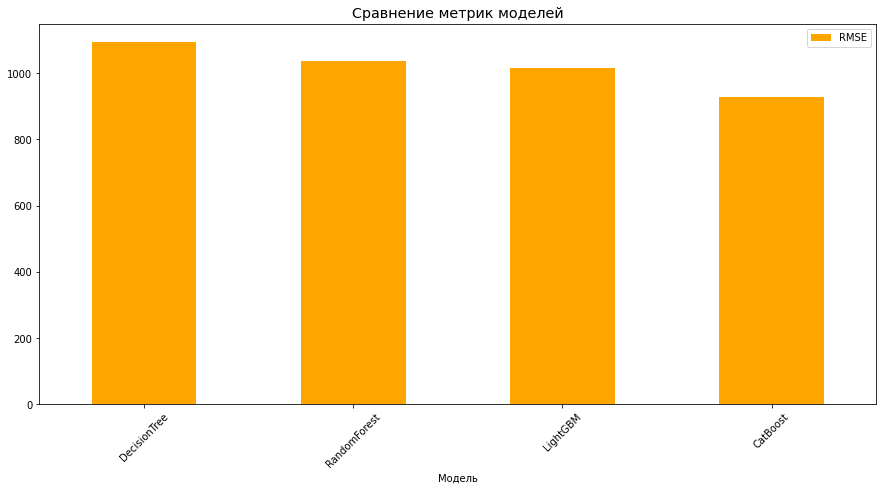

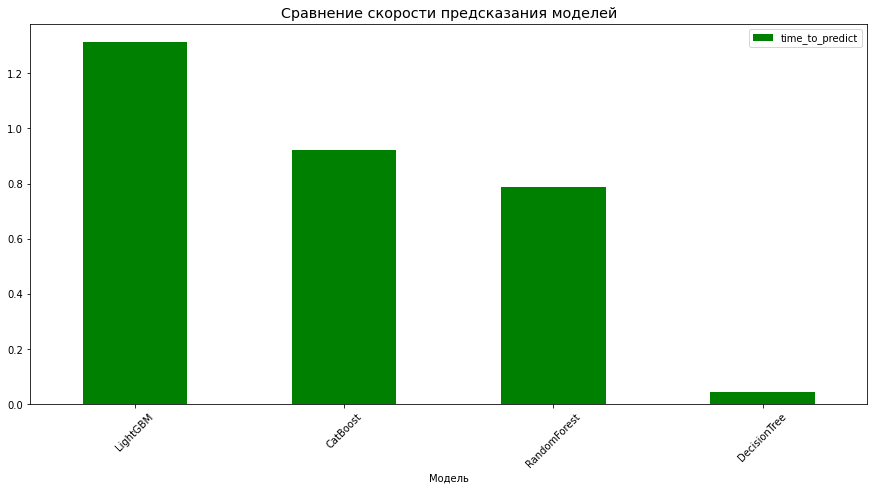

In [ ]:
all_names = pd.DataFrame({'names':['DecisionTree', 'RandomForest', 'LightGBM', 'CatBoost']})
analisys = pd.concat([analisys, all_names], axis=1, join='inner')
display(analisys)

analisys.plot.bar(y='RMSE', x='names', rot=45, figsize=(15,7), color='orange')
plt.title('Сравнение метрик моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

analisys.sort_values(by='time_to_predict', ascending=False)\
.plot.bar(y='time_to_predict', x='names', rot=45, figsize=(15,7), color='green')
plt.title('Сравнение скорости предсказания моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

**Выводы:**
- Создали и обучили модель Линейной регрессии - она показала наихудший результат по исследуемой метрике.
- Создали и обучили модели Дерева решений, Случайного леса, LightGBM и CatBoost
    - наилучший результат по метрике RMSE показала модель CatBoost
    - наилучший результат по скорости предсказания показала модель Дерева решений.
    
Для проверки на тестовой выборке возьмём лучшую модель по метрике RMSE - CatBoost:

In [ ]:
cat_pred = cat_model.predict(test_X)
print(f'RMSE модели CatBoost на тестовой выборке: {mean_squared_error(test_y, cat_pred) ** 0.5}')

RMSE модели CatBoost на тестовой выборке: 1442.8312961853942


**Итоговый вывод:**
RMSE выбранной модели на тестовой выборке составил: 1442.83, следовательно цель достигнута.